In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeCV, LassoCV
import scipy
import math
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn import linear_model

import sys
# import mss
sys.path.append('../')
from mss import visreader as mvis
from mss import mssmain as msm
from mss import align
from mss import dm
from sklearn.metrics import jaccard_score
from scipy.stats import entropy
from scipy import spatial
from scipy.spatial import distance
import urllib
import json
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

D:\python\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\scarlet_07\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Users\scarlet_07\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.



In [15]:
#df = pd.read_csv('../example_data/clustering/testdata_1114_patternrec.csv')
df = pd.read_excel('D:/UW/project/6ppd-experiments/tl/20210226_tlft_repeat/Leaching-dbscan-ACS.xlsx')

In [17]:
result = list(dict.fromkeys([i[:-2] for i in df.iloc[:,3:].columns]))
mean_list = []
for i in result:
    mean_list.append(list(df.iloc[:,3:][df.iloc[:,3:].columns[df.iloc[:,3:].columns.str.contains(i)]].mean(1)))
df_m = pd.DataFrame(mean_list).T
df_m.columns = result
df_m.head()

,15min,30min,1hr,90min,2hr,3hr,4hr,5hr,6hr
0,169276.000000,164346.333333,163164.333333,178341.666667,160225.666667,165668.000000,223768.333333,198829.000000,189258.333333
1,39941.000000,37272.000000,54313.666667,57961.000000,34239.000000,41193.000000,47297.000000,32565.000000,15485.666667
2,20094.666667,15774.333333,20151.666667,21300.333333,19779.666667,20684.000000,23152.666667,21632.333333,18031.333333
3,169276.000000,164346.333333,163164.333333,165837.333333,162335.666667,163667.000000,202659.333333,194240.000000,135941.333333
4,51617.000000,19716.666667,28314.666667,93790.000000,36900.333333,41106.666667,38347.333333,58382.333333,47576.666667


In [36]:
def PCA_report(dataframe, n_components=5, figsize=(5,5)):
    df_p = dataframe.copy()
    x = df_p.values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(x.T) #X : array-like, shape (n_samples, n_features)

    # Plotting the Cumulative Sum of the Explained Variance, use explained variance to choose number of principle componenets
    # you may choose number of componenets that explained > 99% variance
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Pulsar Dataset Explained Variance')
    plt.show()
    print('explained ratio:', pca.explained_variance_ratio_)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x.T)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    principalDf.head()
    plt.style.use('default')
    finalDf = principalDf
    finalDf['label'] = list(df_p.columns)
    principle_1 = finalDf.loc[:,'principal component 1']
    principle_2 = finalDf.loc[:,'principal component 2']
    n = list(df_p.columns)

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(principle_2, principle_1,s=50,marker ='+')
    plt.xlabel('PC2')
    plt.ylabel('PC1')
    plt.title('Principle Component Analysis Result')


    for i, txt in enumerate(n):
        ax.annotate(txt, (principle_2[i], principle_1[i]),rotation=15)

    plt.show()
    
    return

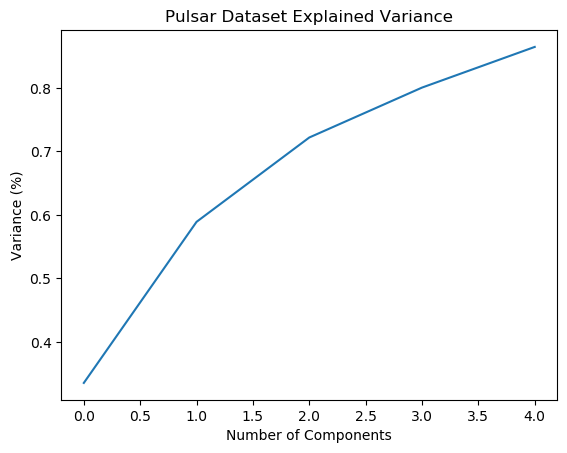

explained ratio: [0.33531992 0.25366946 0.13281326 0.07859495 0.06404697]


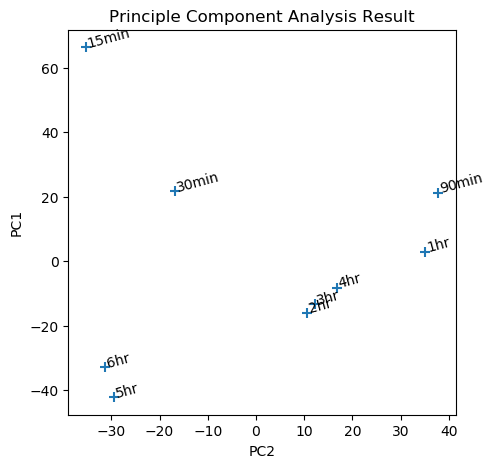

In [37]:
PCA_report(df_m,)

In [328]:
df = df[(df['Average RT (min)'] >= 2) & (df['Average RT (min)'] <=18)].copy()
df.reset_index(inplace=True,drop=True)

In [329]:
source_col = df.columns[df.columns.str.contains('dil-to')]
dfp = df[source_col].copy()
dfp.shape

(5134, 36)

In [330]:
result = list(dict.fromkeys([i[:-2] for i in df.iloc[:,3:].columns]))
mean_list = []
for i in result:
    mean_list.append(list(df.iloc[:,3:][df.iloc[:,3:].columns[df.iloc[:,3:].columns.str.contains(i)]].mean(1)))

In [331]:
df_m = pd.DataFrame(mean_list).T
df_m.columns = result
df_m.head()

,Average,Average sco,20181114_CoulterCreek,20181114_Crescent-Creek-Jan,20181114_Crescent-Creek-May,20181114_MSMS_Miller-Creek-20181025_Site4-HLB,20181114_MSMS_Miller-Creek-20181025_Site5down-HLB,20181114_MSMS_Miller-Creek-20181025_Site8MW-HLB,20181114_RuralCreek,20181114_SR518-Cal_1000mL,...,20181114_SR520-Creek_Mix2,20181114_SR520-Creek_Mix3,20181114_SR520-Creek_Mix4A,20181114_SR520-Creek_Mix4B,20181114_SR520-Creek_Mix5A,20181114_SR520-Creek_Mix5B,20181114_SR520-Creek_Mix6A,20181114_SR520-Creek_Mix6B,20181114_SwanCreek-Dec,20181114_SwanCreek-May
0,18.015,1.0,3204.000000,3622.666667,3607.666667,14036.0,74715.0,39193.0,2674.666667,24611.380952,...,24954.666667,16504.333333,11058.666667,26047.666667,5067.666667,11472.333333,4308.0,5432.333333,5038.666667,2784.000000
1,8.950,1.0,2505.000000,2011.333333,3752.666667,153779.0,146454.0,189119.0,1013.333333,17034.761905,...,9834.333333,6482.666667,4189.666667,4653.666667,4328.000000,2608.666667,2074.0,1836.000000,1676.666667,1781.000000
2,15.485,1.0,2379.000000,3860.666667,3262.333333,147749.0,175420.0,189706.0,1866.000000,35953.666667,...,15688.000000,6701.000000,5127.333333,30882.333333,4585.333333,11360.333333,2768.0,2783.333333,1501.333333,1968.666667
3,96.515,1.0,568.666667,581.333333,1138.666667,40774.0,87411.0,137532.0,625.333333,49141.809524,...,325457.000000,192073.333333,97944.000000,114456.666667,23564.000000,34094.666667,5701.0,8821.666667,1283.666667,500.666667
4,12.185,1.0,0.000000,0.000000,128.333333,0.0,34312.0,17085.0,183.000000,6482.238095,...,7176.333333,4040.333333,1895.000000,4936.333333,456.333333,2153.000000,241.0,557.000000,181.666667,267.000000


In [332]:
result = list(dict.fromkeys([i[:-2] for i in source_col]))
mean_list = []
for i in result:
    mean_list.append(list(dfp[dfp.columns[dfp.columns.str.contains(i)]].mean(1)))

In [333]:
df_mean = pd.DataFrame(mean_list).T
df_mean.columns = result
d_clu = df_mean[df_mean.columns[df_mean.columns.str.contains('518')]].copy()

In [335]:
c_data = d_clu.values
c_norm = [((row-np.mean(row))/np.std(row)) for row in c_data]
#Clean up dataframe
c_norm = np.asarray(c_norm)
d_norm = pd.DataFrame(c_norm)
d_norm['index']=d_clu.index
d_norm.set_index('index',inplace=True)
d_norm.dropna(how='all',inplace=True)
d_norm.columns = d_clu.columns

D:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



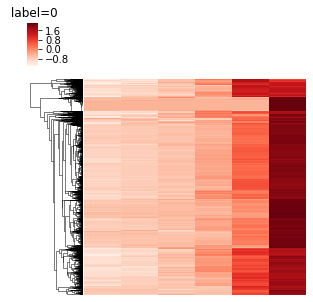

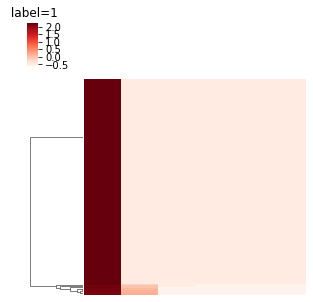

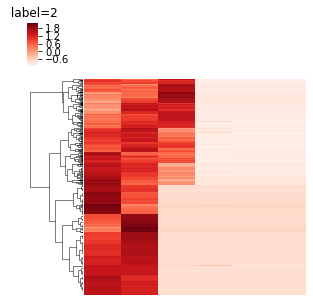

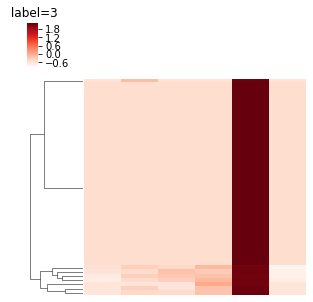

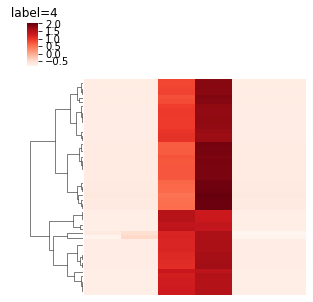

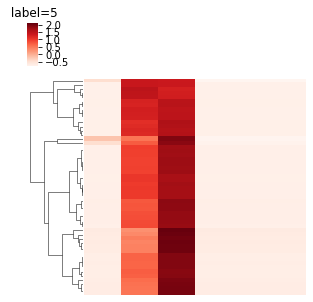

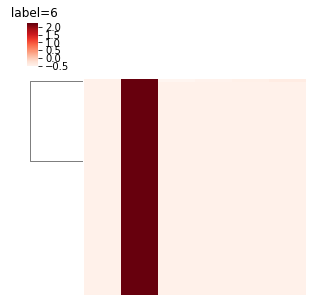

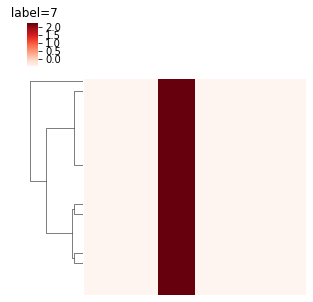

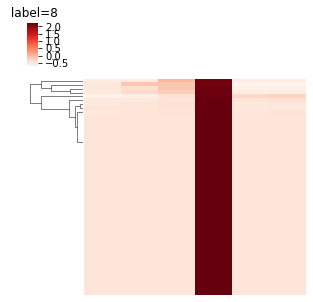

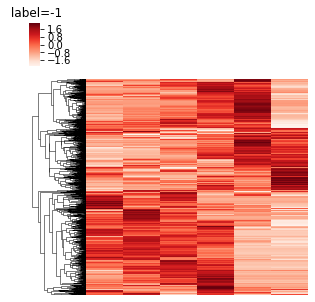

In [337]:
dbscan = cluster.DBSCAN(eps=0.4, min_samples=26).fit(d_norm)
labels = dbscan.labels_
unique_labels = set(dbscan.labels_)

for i,k in enumerate(unique_labels):
    indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
    sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=False,yticklabels=False,xticklabels=False,figsize=(5,5))
    plt.title(' label='+ str(k))
    plt.show()
    
d_init = d_clu.copy()
d_label = d_clu.loc[d_norm.index] #Use the index to match back to the original datasheet
d_label.insert(len(d_clu.columns),"label", dbscan.labels_.tolist())

In [338]:
d_source = df.loc[d_label[d_label['label'] == 0].index].copy()
d_bg = df.loc[d_label[d_label['label'] != 0].index].copy()

In [257]:
#select comparison sample
source_col = '20181114_SR520-Cal-in-DI_400mL'
sample_col = '20181114_RuralCreek'

d_index = df_m.index[df_m[sample_col] >= 2000] #Threshold?
source_index = d_source.index
simp_score = len([i for i in source_index if i in d_index])/len(source_index)
print('simple source prediction score: ', simp_score)

#MSDIAL algorithm, if 2d only consider mz/rt, 3d (plus intensity) need to alter their equations
#Maybe not accurate
union_index = list(set(source_index).union(set(d_index)))
intersec_index = [i for i in source_index if i in d_index]

sl = df_m[source_col]
samplel = df_m[sample_col]
union_b = np.asarray([samplel[i] for i in union_index])
intersec_b = np.asarray([samplel[i] for i in intersec_index])
union_s = np.asarray([sl[i] for i in union_index])
intersec_s = np.asarray([sl[i] for i in intersec_index])
#Normalize?
dot_score = ((np.dot(union_b,union_s)
 /(np.linalg.norm(union_b)
   *np.linalg.norm(union_s)))
/(np.dot(intersec_b,intersec_s)
  /(np.linalg.norm(intersec_b)
    *np.linalg.norm(intersec_s))))
print('dot product score:', dot_score)

#Jaccard score can only be used on label
#log transformed situation
a = list(map(lambda x: 1 if x == 0 else x, sl))
logsl = [int(round((np.log(i)))) for i in a]
b = list(map(lambda x: 1 if x == 0 else x, samplel))
logsamplel = [int(round((np.log(i)))) for i in b]
j_score_raw = jaccard_score(logsl,logsamplel,average='weighted')
print('Jaccard score(raw):', j_score_raw) #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

#Binary transformed situation
binsl = list(map(lambda x: 1 if x > 0 else x, sl))
binsamplel = list(map(lambda x: 1 if x > 0 else x, samplel))
j_score_bin = jaccard_score(binsl,binsamplel,average='binary')
print('Jaccard score(binary):',j_score_bin)

#KL divergence
from scipy.stats import entropy
print('raw data entropy', entropy(sl, samplel))
print('log data entropy', entropy(logsl, logsamplel))
scores = [simp_score, dot_score, j_score_raw,
          j_score_bin, entropy(sl, samplel),
          entropy(logsl, logsamplel)]

simple source prediction score:  0.24611542730299668
dot product score: 0.9869308289057026
Jaccard score(raw): 0.09657863959967716
Jaccard score(binary): 0.6700745473908413
raw data entropy inf
log data entropy inf


In [347]:
def similarity_score(source_col, source_index, sample_col,dataframe, threshold=2000):
    d_index = dataframe.index[dataframe[sample_col] >= threshold] #Threshold?
    simp_score = len([i for i in source_index if i in d_index])/len(source_index)

    union_index = list(set(source_index).union(set(d_index)))
    intersec_index = [i for i in source_index if i in d_index]

    sl = dataframe[source_col]
    samplel = dataframe[sample_col]
    union_b = np.asarray([samplel[i] for i in union_index])
    intersec_b = np.asarray([samplel[i] for i in intersec_index])
    union_s = np.asarray([sl[i] for i in union_index])
    intersec_s = np.asarray([sl[i] for i in intersec_index])
    #Normalize?
    dot_score = ((np.dot(union_b,union_s)
     /(np.linalg.norm(union_b)
       *np.linalg.norm(union_s)))
    /(np.dot(intersec_b,intersec_s)
      /(np.linalg.norm(intersec_b)
        *np.linalg.norm(intersec_s))))
    
#     sl = df_m.iloc[source_index][source_col]
#     samplel = df_m.iloc[source_index][sample_col]
    #Jaccard score can only be used on label
    #log transformed situation
    a = list(map(lambda x: 1 if x == 0 else x, sl))
    logsl = [int(round((np.log(i)))) for i in a]
    b = list(map(lambda x: 1 if x == 0 else x, samplel))
    logsamplel = [int(round((np.log(i)))) for i in b]
    j_score_raw = jaccard_score(logsl,logsamplel,average='weighted')

    #Binary transformed situation
    binsl = list(map(lambda x: 1 if x > 0 else x, sl))
    binsamplel = list(map(lambda x: 1 if x > 0 else x, samplel))
    j_score_bin = jaccard_score(binsl,binsamplel,average='binary')

    #KL divergence
    from scipy.stats import entropy
    scores = [simp_score, dot_score, j_score_raw,
              j_score_bin, entropy(sl, samplel),
              entropy(logsl, logsamplel)]
    return scores

In [292]:
df_m = df.copy()

In [340]:
df_m.columns[df_m.columns.str.contains('518')]

Index(['20181114_SR518-Cal_1000mL', '20181114_SR518-Cal_1000mL_dil-to-1mL',
       '20181114_SR518-Cal_1000mL_dil-to-10mL',
       '20181114_SR518-Cal_1000mL_dil-to-25mL',
       '20181114_SR518-Cal_1000mL_dil-to-60mL',
       '20181114_SR518-Cal_1000mL_dil-to-160mL',
       '20181114_SR518-Cal_1000mL_dil-to-400mL'],
      dtype='object')

In [348]:
score_list = []
for i in df_m.columns[df_m.columns.str.contains('Creek')]:
    score_list.append(similarity_score( '20181114_SR518-Cal_1000mL_dil-to-400mL',d_source.index, i, df_m))
df_score = pd.DataFrame(score_list)
df_score.columns = ['Simple score', 'dot product', 'jaccard_raw', 'jaccard_bin', 'entropy_raw', 'entropy_log']
df_score.index = df_m.columns[df_m.columns.str.contains('Creek')]

In [349]:
df_score

,Simple score,dot product,jaccard_raw,jaccard_bin,entropy_raw,entropy_log
20181114_CoulterCreek,0.375505,0.998440,0.173033,0.570078,inf,inf
20181114_Crescent-Creek-Jan,0.445837,0.998594,0.234587,0.630891,inf,inf
20181114_Crescent-Creek-May,0.428052,0.998599,0.203124,0.600000,inf,inf
20181114_MSMS_Miller-Creek-20181025_Site4-HLB,0.711399,1.031100,0.228329,0.604016,inf,inf
20181114_MSMS_Miller-Creek-20181025_Site5down-HLB,0.837510,1.057410,0.133582,0.578373,inf,inf
20181114_MSMS_Miller-Creek-20181025_Site8MW-HLB,0.815279,1.051762,0.134923,0.571624,inf,inf
20181114_RuralCreek,0.288601,0.988674,0.155044,0.568873,inf,inf
20181114_SR520-Creek_Mix1,0.825384,0.994348,0.200954,0.628351,inf,inf
20181114_SR520-Creek_Mix2,0.799515,0.998852,0.206951,0.632134,inf,inf
20181114_SR520-Creek_Mix3,0.763137,0.996767,0.203662,0.631411,inf,inf


In [ ]:
# Alignment assessment?
#1. find closest neighbour for each mz/RT
#2. calc entropy?

def dist_euclidean(elem1, elem2):
    t_sum=0
    for i in range(len(elem1)):
        for j in range(len(elem1[0])):
            t_sum+= np.square(elem1[i][j]-elem2[i][j])
    return np.sqrt(t_sum)

def dist_cosine(elem1, elem2):
    temp1=[]
    temp2=[]
    for i in range(len(elem1)):
        temp1.extend(elem1[i])
        temp2.extend(elem2[i])
    return distance.cosine(temp1, temp2)

from scipy.stats import entropy
def dist_KL_row_avg(elem1, elem2):
    Y=[]
    for i in range(len(elem1)):
        Y.append(entropy(elem1[i], elem2[i]))
    return np.average(Y)

In [ ]:
a = np.array([[200.9,300.5],[0,1]])
b = np.array([[200.8553,300.4319],[0,1]])
# The smaller the better
print('euclidean dist:', dist_euclidean(a,b))
print('cos similarity:', dist_cosine(a, b))
print('KL divergence avg:', dist_KL_row_avg(a, b))

In [ ]:
#Next: using dummy data to assess the alignment score system
import pickle
with open('./dummydata/sourcepair.data', 'rb') as filehandle:
    # read the data as binary data stream
    source = pickle.load(filehandle)

In [ ]:
with open('./dummydata/randsource_missing_pattern.data', 'rb') as f:
    # read the data as binary data stream
    source_miss = pickle.load(f)

In [ ]:
data=[]
for i_s,j in enumerate(source):
    zipsource = list(zip(j[0],j[1]))
    for i_miss in np.arange(i_s * 5,(i_s + 1) * 5):
        zipmiss = list(zip(source_miss[i_miss][0], source_miss[i_miss][1]))
        source_pair = []
        miss_pair = []
        for i in zipmiss:
            _,index = spatial.KDTree(zipsource).query(i)
            #if abs(i[0] - zipsource[index][0]) <= 200*5e-6 and abs(i[1] - zipsource[index][1]) < 0.2:
            source_pair.append(zipsource[index])
            miss_pair.append(i)
        data.append([i_s, dist_euclidean(source_pair,miss_pair),
               dist_cosine(source_pair,miss_pair),
               dist_KL_row_avg(source_pair,miss_pair),
               len(miss_pair)/200])
#         print('euclidean dist:', dist_euclidean(source_pair,miss_pair))
#         print('cos similarity:', dist_cosine(source_pair,miss_pair))
#         print('KL divergence avg:', dist_KL_row_avg(source_pair,miss_pair))
#         print('total match:', len(miss_pair)/200)
dfilter=pd.DataFrame(data)
dfilter.columns = ['source #', 'euclidean dist', 'cos score', 'KL divergence', 'simple match']

In [ ]:
#dfilter.to_csv('./dummydata/d_wofilter_alignmentassessment.csv')

In [124]:
def mf_calculator(mass, mass_error = 10,
                  mfRange='C0-100H0-200N0-20O0-20P0-50',
                  maxresults = 20,
                  integerUnsaturation = False):
    chemcalcURL = 'https://www.chemcalc.org/chemcalc/em'
    massRange = mass * mass_error * 1e-6

    # Define the parameters and send them to Chemcalc
    # other options(mass tolerance, unsaturation, etc.params = {
    params = {
        'mfRange': mfRange,
        'monoisotopicMass': mass,
        'massRange': massRange,
        'integerUnsaturation': integerUnsaturation
    }

    f = urllib.parse.urlencode(params)
    f = f.encode('utf-8')
    response = urllib.request.urlopen(chemcalcURL, f)

    jsondata = response.read()
    data = json.loads(jsondata)
    dataframe = pd.DataFrame(data['results'])
    dataframe.drop(columns='info', inplace=True)
    dataframe.columns = ['Exact Mass', 'Formula', 'Unsat', 'Mass error (Da)', 'Mass error (ppm)']
    dataframe = dataframe[:maxresults].copy()
    return dataframe

In [130]:
test.set_index('Formula',inplace=True)

In [131]:
test

,Exact Mass,Unsat,Mass error (Da),Mass error (ppm)
Formula,,,,
C3H19N14O3,299.176456,1.5,-0.000044,-0.1486
C14H26N3O2P,299.176264,4.0,-0.000236,-0.7898
C18H23N2O2,299.175953,8.5,-0.000547,-1.8284
C16H28O3P,299.177606,3.5,0.001106,3.6981
C8H27N7OP2,299.175232,0.0,-0.001268,-4.2390
C5H21N11O4,299.177798,1.0,0.001298,4.3392
CH17N17O2,299.175113,2.0,-0.001387,-4.6365
C12H24N6OP,299.174921,4.5,-0.001579,-5.2777
C16H21N5O,299.174610,9.0,-0.001890,-6.3163


In [129]:
test = mf_calculator(299.1765)
test

,Exact Mass,Formula,Unsat,Mass error (Da),Mass error (ppm)
0,299.176456,C3H19N14O3,1.5,-0.000044,-0.1486
1,299.176264,C14H26N3O2P,4.0,-0.000236,-0.7898
2,299.175953,C18H23N2O2,8.5,-0.000547,-1.8284
3,299.177606,C16H28O3P,3.5,0.001106,3.6981
4,299.175232,C8H27N7OP2,0.0,-0.001268,-4.2390
5,299.177798,C5H21N11O4,1.0,0.001298,4.3392
6,299.175113,CH17N17O2,2.0,-0.001387,-4.6365
7,299.174921,C12H24N6OP,4.5,-0.001579,-5.2777
8,299.174610,C16H21N5O,9.0,-0.001890,-6.3163
9,299.173889,C6H25N10P2,0.5,-0.002611,-8.7270
